# Minecraft Classification
Based on the GitHub](https://github.com/GDSC-EPITA/gdsc-computer-vision-workshop)

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# set the seed for reproductiblity
SEED = 123
tf.keras.utils.set_random_seed(SEED)

In [3]:
# check the available devices (see the GitHub for more info)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
batch_size = 256
img_size = (18, 32)
train_data_directory = "/kaggle/input/gdsc-epita-minecraft-biome-classification/dataset_training/"

# import the data using the handy "image_dataset_from_directory"
# function from TensorFlow


ds_train, ds_val = tf.keras.utils.image_dataset_from_directory(
    train_data_directory,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    interpolation="bicubic",

)
class_names = ds_train.class_names
n_classes = len(class_names)
print(class_names)

Found 17387 files belonging to 19 classes.
Using 13910 files for training.
Using 3477 files for validation.
['00_plains', '01_snowy_tundra', '02_snowy_mountains', '03_beach', '04_desert_hills', '05_wooded_hills', '06_taiga_hills', '07_desert', '08_jungle', '09_birch_forest', '10_dark_forest', '11_mountains', '12_snowy_taiga', '13_wooded_mountains', '14_savanna', '15_forest', '16_taiga', '17_swamp', '18_river']


In [5]:
from tensorflow.keras import layers
# define data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),  
])

# apply data augmentation to the training data
ds_train = ds_train.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# apply the same augmentation to the validation data
ds_val = ds_val.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [6]:
import os


counts_per_class = []

# The subdirectories in your parent directory should be your class names
for class_dir in os.listdir(train_data_directory):
    class_count = len(os.listdir(os.path.join(train_data_directory, class_dir)))
    counts_per_class.append(class_count)

class_weights = {}
total_samples = len(ds_train) * batch_size

for i in range(19):
    class_weights[i] = total_samples / counts_per_class[i]
    
class_weights

{0: 47.567567567567565,
 1: 27.5,
 2: 10.225127087872186,
 3: 12.471213463241806,
 4: 5.742251223491028,
 5: 6.342342342342342,
 6: 37.64705882352941,
 7: 19.830985915492956,
 8: 62.857142857142854,
 9: 37.64705882352941,
 10: 19.664804469273744,
 11: 15.609756097560975,
 12: 70.4,
 13: 5.193655477683512,
 14: 23.157894736842106,
 15: 55.43307086614173,
 16: 24.920353982300885,
 17: 9.798190675017397,
 18: 43.190184049079754}

In [7]:
def preprocess(x, y):
    x = tf.keras.layers.Rescaling(1./255)(x)
    #x = tf.image.random_flip_left_right(x) # randomly flip image
    return x, y

def test_preprocess(x):
    x = tf.keras.layers.Rescaling(1./255)(x)
    return x
# preprocess the datasets by normalizing, flipping, caching and shuffling them
ds_train = ds_train.map(preprocess).cache().prefetch(tf.data.AUTOTUNE).shuffle(len(ds_train))
ds_val = ds_val.map(preprocess).cache().prefetch(tf.data.AUTOTUNE).shuffle(len(ds_val))


In [8]:
# Take one sample from the training dataset
for image, label in ds_train.take(1):
    # Now image is a single example from your dataset, so you can check its shape:
    print('Train dataset image shape: ', image.shape)

# Repeat the process for the validation dataset
for image, label in ds_val.take(1):
    print('Validation dataset image shape: ', image.shape)
    
    # Number of batches in the training dataset
print('Number of batches in train dataset: ', len(list(ds_train)))

# Number of batches in the validation dataset
print('Number of batches in validation dataset: ', len(list(ds_val)))

Train dataset image shape:  (256, 18, 32, 3)
Validation dataset image shape:  (256, 18, 32, 3)
Number of batches in train dataset:  55
Number of batches in validation dataset:  14


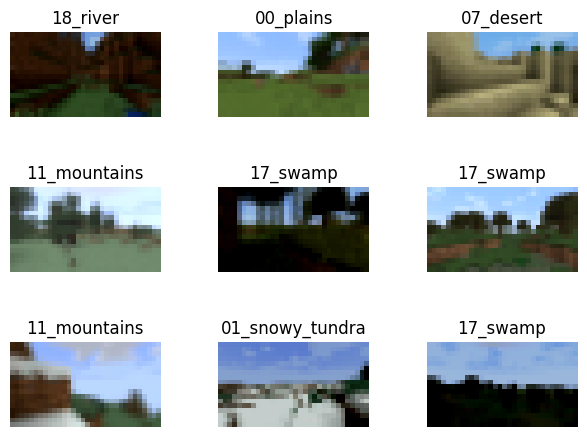

In [9]:
# As a demonstration, let's visualize some pieces of data
def visualize_examples():
    one_batch = ds_train
    grid_size = 3
    fig, axs = plt.subplots(grid_size, grid_size)
    fig.tight_layout()
    for images, labels in one_batch:
        for i, data in enumerate(zip(images, labels)):
            if i >= grid_size * grid_size:
                break
            image, label = data
            axs[i // grid_size, i % grid_size].imshow(image)
            axs[i // grid_size, i % grid_size].set_title(class_names[np.argmax(label)])
            axs[i // grid_size, i % grid_size].set_axis_off()
        break
    plt.show()
visualize_examples()

In [10]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_accuracy', patience=6, verbose=6, restore_best_weights=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.00001, verbose=1)

In [11]:
"""from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Resizing
from keras_tuner import HyperModel, RandomSearch

init_shape=(18, 32, 3)
input_shape=(32, 64, 3)

class BiomeClassifierHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential([
            # First convolution block
            Resizing(32, 64, interpolation="bicubic", input_shape=init_shape),
            Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=16), kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"),
            BatchNormalization(),
            Conv2D(filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=16), kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            # Second convolution block
            Conv2D(filters=hp.Int('conv_3_filters', min_value=64, max_value=256, step=32), kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"),
            BatchNormalization(),
            Conv2D(filters=hp.Int('conv_4_filters', min_value=64, max_value=256, step=32), kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            # Third convolution block
            Conv2D(filters=hp.Int('conv_5_filters', min_value=128, max_value=512, step=64), kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"),
            BatchNormalization(),
            Conv2D(filters=hp.Int('conv_6_filters', min_value=128, max_value=512, step=64), kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            # Flatten the tensor output
            Flatten(),

            # Fully connected layers
            Dense(hp.Int('dense_1_units', min_value=256, max_value=1024, step=128), activation='relu'),
            BatchNormalization(),
            Dropout(rate=hp.Float('dropout_1_rate', min_value=0.0, max_value=0.6, step=0.1)),
            Dense(hp.Int('dense_2_units', min_value=256, max_value=1024, step=128), activation='relu'),
            BatchNormalization(),
            Dropout(rate=hp.Float('dropout_2_rate', min_value=0.0, max_value=0.6, step=0.1)),

            # Output layer
            Dense(19, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

hypermodel = BiomeClassifierHyperModel()

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='output',
    project_name='BiomeClassifier'
)

# Replace X_train, X_val, y_train, y_val with your data
tuner.search(ds_train, epochs=100, validation_data=ds_val, callbacks = [reduce_lr, early_stop])"""

'from keras.models import Sequential\nfrom keras.optimizers import Adam\nfrom keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Resizing\nfrom keras_tuner import HyperModel, RandomSearch\n\ninit_shape=(18, 32, 3)\ninput_shape=(32, 64, 3)\n\nclass BiomeClassifierHyperModel(HyperModel):\n    def build(self, hp):\n        model = Sequential([\n            # First convolution block\n            Resizing(32, 64, interpolation="bicubic", input_shape=init_shape),\n            Conv2D(filters=hp.Int(\'conv_1_filters\', min_value=32, max_value=128, step=16), kernel_size=(3, 3), activation=\'relu\', padding=\'same\', kernel_initializer="he_normal"),\n            BatchNormalization(),\n            Conv2D(filters=hp.Int(\'conv_2_filters\', min_value=32, max_value=128, step=16), kernel_size=(3, 3), activation=\'relu\', padding=\'same\', kernel_initializer="he_normal"),\n            BatchNormalization(),\n            MaxPooling2D(pool_size=(2, 2)),\n\n            

from keras_tuner import BayesianOptimization
num_trials = 200

def model_builder(hp):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Resizing(32, 64, interpolation="bicubic", input_shape=(18,32,3)))
    
    # Tune the number of filters in the first Conv2D layer
    hp_filters = hp.Int('filters', min_value=32, max_value=256, step=32)
    model.add(tf.keras.layers.Conv2D(filters=hp_filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(filters=hp_filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    # Repeat this block two more times
    for i in range(2):
        model.add(tf.keras.layers.Conv2D(filters=hp_filters*(2**(i+1)), kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(filters=hp_filters*(2**(i+1)), kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.6, step=0.05)
    
    # Tune the number of units in the Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=1028, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(hp_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(hp_dropout))

    model.add(tf.keras.layers.Dense(19, activation='softmax'))
    
    
    model.compile(loss='categorical_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = BayesianOptimization(
    model_builder,
    objective='val_accuracy',
    max_trials=num_trials,
    executions_per_trial=3,
    directory='my_dir',
    project_name='keras_tuner_bayesian_optimization')

# Perform the hyperparameter tuning
tuner.search(ds_train,
             epochs=100,
             validation_data=ds_val,
            callbacks = [early_stop, reduce_lr])

best_hps=tuner.get_best_hyperparameters(num_trials=num_trials)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, and the Dense layer {best_hps.get('filters')}, and the best droput {best_hps.get('dropout')}.
""")

best_model = model = tuner.hypermodel.build(best_hps)

In [12]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Resizing

init_shape=(18, 32, 3)
input_shape=(32, 64, 3)


model = tf.keras.Sequential([
    # First convolution block
   # Resizing(32, 64, interpolation="bicubic", input_shape=init_shape),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same',kernel_initializer="he_normal", input_shape=init_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    # Second convolution block
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    # Third convolution block
    tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    # Flatten the tensor output
    tf.keras.layers.Flatten(),

    # Fully connected layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.45),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.45),

    # Output layer
    tf.keras.layers.Dense(19, activation='softmax')
])



model.compile(loss='categorical_crossentropy',
              optimizer='Nadam',
              metrics=['accuracy'])

model.build()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 32, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 18, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 32, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 18, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 16, 256)       0         
 )                                                               
                                                      

In [13]:
def count_layers(model):
   num_layers = len(model.layers)
   for layer in model.layers:
      if isinstance(layer, tf.keras.Model):
         num_layers += count_layers(layer)
   return num_layers

n_layers = count_layers(model)
print(n_layers)
# check that the number of layers is matching the rules
#assert n_layers <= 22

23


In [14]:

# calculate the number of batches in the train set
num_batches_train = tf.data.experimental.cardinality(ds_train).numpy()

# calculate the number of batches in the validation set
num_batches_val = tf.data.experimental.cardinality(ds_val).numpy()


history1 = model.fit(
    ds_train,
    epochs=100,
    validation_data=ds_val,
    batch_size=batch_size,
    steps_per_epoch=num_batches_train,
    validation_steps=num_batches_val,
    max_queue_size=500,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stop],
    use_multiprocessing=True,
    workers=1
)

Epoch 1/100
55/55 [==============================] - 34s 209ms/step - loss: 51.8523 - accuracy: 0.4664 - val_loss: 10.1896 - val_accuracy: 0.1156 - lr: 0.0010
Epoch 2/100
55/55 [==============================] - 8s 142ms/step - loss: 30.4456 - accuracy: 0.6081 - val_loss: 2.2296 - val_accuracy: 0.3747 - lr: 0.0010
Epoch 3/100
55/55 [==============================] - 8s 142ms/step - loss: 25.5174 - accuracy: 0.6543 - val_loss: 2.8964 - val_accuracy: 0.3768 - lr: 0.0010
Epoch 4/100
55/55 [==============================] - 8s 140ms/step - loss: 22.2645 - accuracy: 0.6830 - val_loss: 2.7554 - val_accuracy: 0.3172 - lr: 0.0010
Epoch 5/100
55/55 [==============================] - 8s 141ms/step - loss: 20.0757 - accuracy: 0.7077 - val_loss: 2.4753 - val_accuracy: 0.3822 - lr: 0.0010
Epoch 6/100
55/55 [==============================] - 8s 142ms/step - loss: 18.2993 - accuracy: 0.7219 - val_loss: 1.7414 - val_accuracy: 0.5177 - lr: 0.0010
Epoch 7/100
55/55 [==============================] - 8s 

# calculate the number of batches in the train set
num_batches_train = tf.data.experimental.cardinality(ds_train).numpy()

# calculate the number of batches in the validation set
num_batches_val = tf.data.experimental.cardinality(ds_val).numpy()


with tf.device("/GPU:0"):
    history2 = best_model.fit(
        ds_train,
        epochs=100,
        validation_data=ds_val,
        batch_size=batch_size,
        steps_per_epoch=num_batches_train,
        validation_steps=num_batches_val,
        max_queue_size=500,
        class_weight=class_weights,
        callbacks=[reduce_lr, early_stop],
        use_multiprocessing=True,
        workers=1
    )

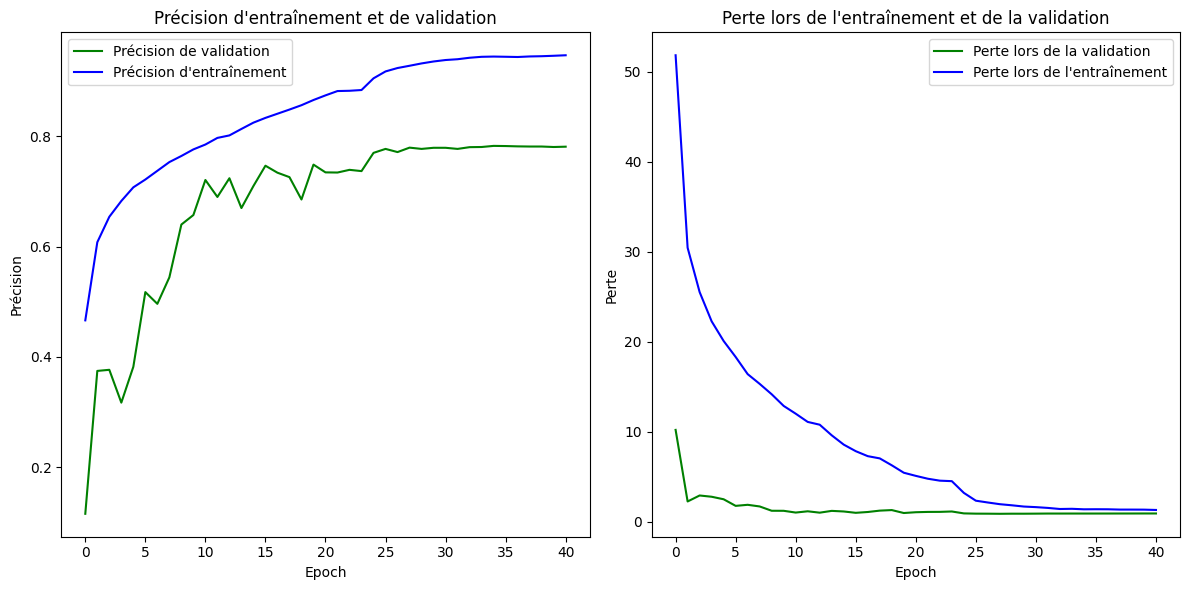

14/14 [==============================] - 1s 42ms/step - loss: 0.8877 - accuracy: 0.7829
Précision du modèle sur l'ensemble de test: 78.29%


In [15]:
def training_plot(history):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['val_accuracy'], 'g', label="Précision de validation")
    plt.plot(history.history['accuracy'], 'b', label="Précision d'entraînement")
    plt.title("Précision d'entraînement et de validation")
    plt.xlabel("Epoch")
    plt.ylabel("Précision")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'], 'g', label="Perte lors de la validation")
    plt.plot(history.history['loss'], 'b', label="Perte lors de l'entraînement")
    plt.title("Perte lors de l'entraînement et de la validation")
    plt.xlabel("Epoch")
    plt.ylabel("Perte")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

training_plot(history1)

test_score = model.evaluate(ds_val)
accuracy = test_score[1] * 100
print(f"Précision du modèle sur l'ensemble de test: {accuracy:.2f}%")

In [16]:
test_data_file = "/kaggle/input/gdsc-epita-minecraft-biome-classification/dataset_test.npy"
test_data = np.load(test_data_file)

ds_test = tf.data.Dataset.from_tensor_slices(test_data).batch(batch_size)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE).cache()
ds_test = ds_test.map(test_preprocess).map(lambda x: tf.image.resize(x, img_size))

In [17]:
res = model.predict(ds_test).argmax(axis=1)
df = pd.DataFrame({"label":res})
df.to_csv("submission.csv", index_label="id")

10/10 [==============================] - 3s 254ms/step
